### Imports and Data Generation

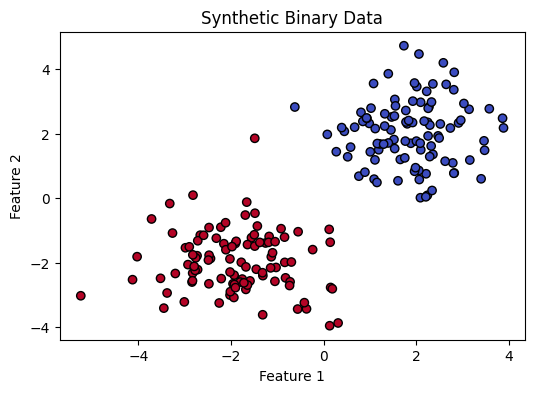

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

def generate_data(n_samples=200):
    """
    Generates two blobs of data for binary classification.
    """
    # Class 0: Centered at (2, 2)
    X0 = np.random.randn(n_samples // 2, 2) + np.array([2, 2])
    Y0 = np.zeros((n_samples // 2, 1))

    # Class 1: Centered at (-2, -2)
    X1 = np.random.randn(n_samples // 2, 2) + np.array([-2, -2])
    Y1 = np.ones((n_samples // 2, 1))

    X = np.vstack((X0, X1))
    Y = np.vstack((Y0, Y1))

    # Shuffle data
    indices = np.random.permutation(n_samples)
    return X[indices], Y[indices]

# Generate and visualize
X, Y = generate_data()

plt.figure(figsize=(6, 4))
plt.scatter(X[:,0], X[:,1], c=Y.flatten(), cmap='coolwarm', edgecolors='k')
plt.title("Synthetic Binary Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Activation Functions and Derivatives

In [21]:
class Activations:
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def sigmoid_derivative(z):
        s = Activations.sigmoid(z)
        return s * (1 - s)

    @staticmethod
    def tanh(z):
        return np.tanh(z)

    @staticmethod
    def tanh_derivative(z):
        t = np.tanh(z)
        return 1 - t**2

    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def relu_derivative(z):
        return (z > 0).astype(float)
    
    @staticmethod
    def scaled_tanh(z):
        return 0.5*(np.tanh(z)+1)
    
    @staticmethod
    def scaledtanh_derivative(z):
        t = np.tanh(z)
        return 0.5*(1 - t**2)
    
    @staticmethod
    def leaky_relu(z, alpha=0.01):
        return np.where(z > 0, z, alpha * z)
    @staticmethod
    def leaky_relu_derivative(z, alpha=0.01):
        return np.where(z > 0, 1.0, alpha)

    @staticmethod
    def elu(z, alpha=1.0):
        return np.where(z > 0, z, alpha * (np.exp(z) - 1))
    @staticmethod
    def elu_derivative(z, alpha=1.0):
        # Derivative for z <= 0 is alpha * exp(z) -> which is elu(z) + alpha
        return np.where(z > 0, 1.0, alpha * np.exp(z))
    
    @staticmethod
    def swish(z):
        # f(z) = z * sigmoid(z)
        return z * (1 / (1 + np.exp(-z)))

    @staticmethod
    def swish_derivative(z):
        # f'(z) = swish(z) + sigmoid(z) * (1 - swish(z))
        s = 1 / (1 + np.exp(-z))
        f = z * s
        return f + s * (1 - f)

    @staticmethod
    def softplus(z):
        # f(z) = ln(1 + e^z)
        # Smooth approximation of ReLU
        return np.log(1 + np.exp(z))

    @staticmethod
    def softplus_derivative(z):
        # f'(z) = sigmoid(z)
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def softsign(z):
        # f(z) = z / (1 + |z|)
        # Range: (-1, 1). Simpler calculation than Tanh.
        return z / (1 + np.abs(z))

    @staticmethod
    def softsign_derivative(z):
        # f'(z) = 1 / (1 + |z|)^2
        return 1 / ((1 + np.abs(z))**2)

    @staticmethod
    def selu(z, alpha=1.67326, scale=1.0507):
        # Scaled Exponential Linear Unit
        # Scale * (z if z > 0 else alpha * (exp(z) - 1))
        return scale * np.where(z > 0, z, alpha * (np.exp(z) - 1))

    @staticmethod
    def selu_derivative(z, alpha=1.67326, scale=1.0507):
        # Derivative for z <= 0 is scale * alpha * exp(z)
        return scale * np.where(z > 0, 1.0, alpha * np.exp(z))

### Manual Implementation of the confusion matrix

In [22]:
def calculate_metrics(y_true, y_pred):
    """
    Computes accuracy and confusion matrix elements (TP, TN, FP, FN)
    """
    m = y_true.shape[0]
    accuracy = np.mean(y_true == y_pred)
    
    # Manual Confusion Matrix
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    return accuracy, np.array([[TN, FP], [FN, TP]])

### The Single Neuron Class (Scratch Implementation)

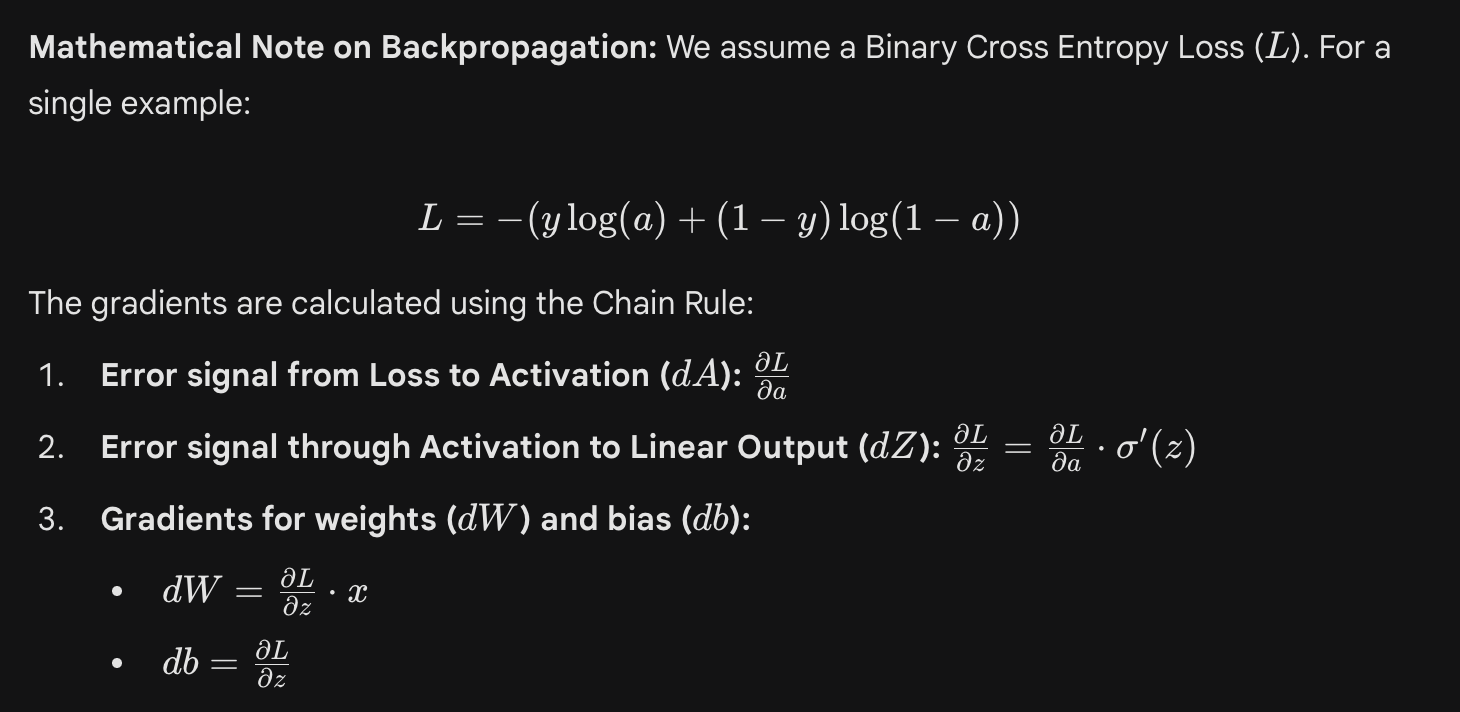

In [23]:
class SingleNeuron:
    def __init__(self, input_dim, activation_name='sigmoid'):
        
        self.w = np.random.randn(input_dim, 1) * 0.01
        self.b = 0.0
        
        self.activation_name = activation_name
        if activation_name == 'sigmoid':
            self.act_func = Activations.sigmoid
            self.act_deriv = Activations.sigmoid_derivative
        elif activation_name == 'tanh':
            self.act_func = Activations.tanh
            self.act_deriv = Activations.tanh_derivative
        elif activation_name == 'scaled_tanh':
            self.act_func = Activations.scaled_tanh
            self.act_deriv = Activations.scaledtanh_derivative
        elif activation_name == 'relu':
            self.act_func = Activations.relu
            self.act_deriv = Activations.relu_derivative
        elif activation_name == 'leaky_relu':
            self.act_func = Activations.leaky_relu
            self.act_deriv = Activations.leaky_relu_derivative
        elif activation_name == 'elu':
            self.act_func = Activations.elu
            self.act_deriv = Activations.elu_derivative
        elif activation_name == 'swish':
            self.act_func = Activations.swish
            self.act_deriv = Activations.swish_derivative
        elif activation_name == 'softplus':
            self.act_func = Activations.softplus
            self.act_deriv = Activations.softplus_derivative
        elif activation_name == 'softsign':
            self.act_func = Activations.softsign
            self.act_deriv = Activations.softsign_derivative
        elif activation_name == 'selu':
            self.act_func = Activations.selu
            self.act_deriv = Activations.selu_derivative
        else:
            raise ValueError(f"Unknown activation: {activation_name}")

    def forward(self, X):
        """
        Forward propagation: Z = Xw + b, A = activation(Z)
        """
        self.X_input = X 
        self.Z = np.dot(X, self.w) + self.b
        self.A = self.act_func(self.Z)
        return self.A

    def backward(self, Y, learning_rate):
        """
        Backward propagation to calculate gradients and update weights.
        """
        m = Y.shape[0]
        
        
        epsilon = 1e-15
        A_clipped = np.clip(self.A, epsilon, 1 - epsilon)
        
        # Derivative of Binary Cross Entropy Loss
        dA = - (np.divide(Y, A_clipped) - np.divide(1 - Y, 1 - A_clipped))
        
       
        dZ = dA * self.act_deriv(self.Z)
        
        dw = (1 / m) * np.dot(self.X_input.T, dZ)
        db = (1 / m) * np.sum(dZ)
        
        self.w -= learning_rate * dw
        self.b -= learning_rate * db
        
    def compute_loss(self, Y):
        m = Y.shape[0]
        epsilon = 1e-15
        A_clipped = np.clip(self.A, epsilon, 1 - epsilon)
        loss = - (1/m) * np.sum(Y * np.log(A_clipped) + (1 - Y) * np.log(1 - A_clipped))
        return loss

    def predict(self, X):
        A = self.forward(X)
        return (A > 0.5).astype(int)

### Training Loop and Comparison

In [24]:
def train_model(X, Y, activation, epochs=1000, lr=0.1):
    neuron = SingleNeuron(input_dim=X.shape[1], activation_name=activation)
    loss_history = []
    acc_history = []
    
    for i in range(epochs):
        # 1. Forward
        neuron.forward(X)
        
        # 2. Track Metrics (Loss & Accuracy)
        loss = neuron.compute_loss(Y)
        predictions = (neuron.A > 0.5).astype(int)
        acc = np.mean(Y == predictions)
        
        loss_history.append(loss)
        acc_history.append(acc)
        
        # 3. Backward
        neuron.backward(Y, learning_rate=lr)
            
    return neuron, loss_history, acc_history

# List of activations to test
activations_to_test = ['sigmoid', 'tanh', 'scaled_tanh', 'relu', 'leaky_relu', 'elu', 'swish', 'softplus', 'softsign', 'selu']
results = {}

print(f"{'Activation':<15} | {'Final Loss':<10} | {'Final Acc':<10}")
print("-" * 45)

for act in activations_to_test:
    # Use smaller LR for ReLU-family to prevent explosion
    lr = 0.01 if 'relu' in act or 'elu' in act else 0.1
    
    model, losses, accs = train_model(X, Y, act, epochs=500, lr=lr)
    results[act] = {
        'model': model,
        'losses': losses,
        'accs': accs
    }
    print(f"{act:<15} | {losses[-1]:.4f}     | {accs[-1]:.4f}")

Activation      | Final Loss | Final Acc 
---------------------------------------------
sigmoid         | 0.0122     | 0.9950
tanh            | 21.5871     | 0.3750
scaled_tanh     | 0.0051     | 1.0000
relu            | 0.1727     | 0.9950
leaky_relu      | 0.1727     | 0.9950
elu             | 0.1727     | 0.9950
swish           | 0.0000     | 1.0000
softplus        | 0.0000     | 1.0000
softsign        | 0.6032     | 0.9800
selu            | 0.1727     | 0.9950


/var/folders/mr/s_4_4nwn31n3tnqmq165d4fh0000gn/T/ipykernel_1750/1929149126.py:46: RuntimeWarning: overflow encountered in exp
  return np.where(z > 0, z, alpha * (np.exp(z) - 1))
/var/folders/mr/s_4_4nwn31n3tnqmq165d4fh0000gn/T/ipykernel_1750/1929149126.py:50: RuntimeWarning: overflow encountered in exp
  return np.where(z > 0, 1.0, alpha * np.exp(z))
/var/folders/mr/s_4_4nwn31n3tnqmq165d4fh0000gn/T/ipykernel_1750/1929149126.py:55: RuntimeWarning: overflow encountered in exp
  return z * (1 / (1 + np.exp(-z)))
/var/folders/mr/s_4_4nwn31n3tnqmq165d4fh0000gn/T/ipykernel_1750/1929149126.py:60: RuntimeWarning: overflow encountered in exp
  s = 1 / (1 + np.exp(-z))
/var/folders/mr/s_4_4nwn31n3tnqmq165d4fh0000gn/T/ipykernel_1750/1929149126.py:90: RuntimeWarning: overflow encountered in exp
  return scale * np.where(z > 0, z, alpha * (np.exp(z) - 1))
/var/folders/mr/s_4_4nwn31n3tnqmq165d4fh0000gn/T/ipykernel_1750/1929149126.py:95: RuntimeWarning: overflow encountered in exp
  return scale * n

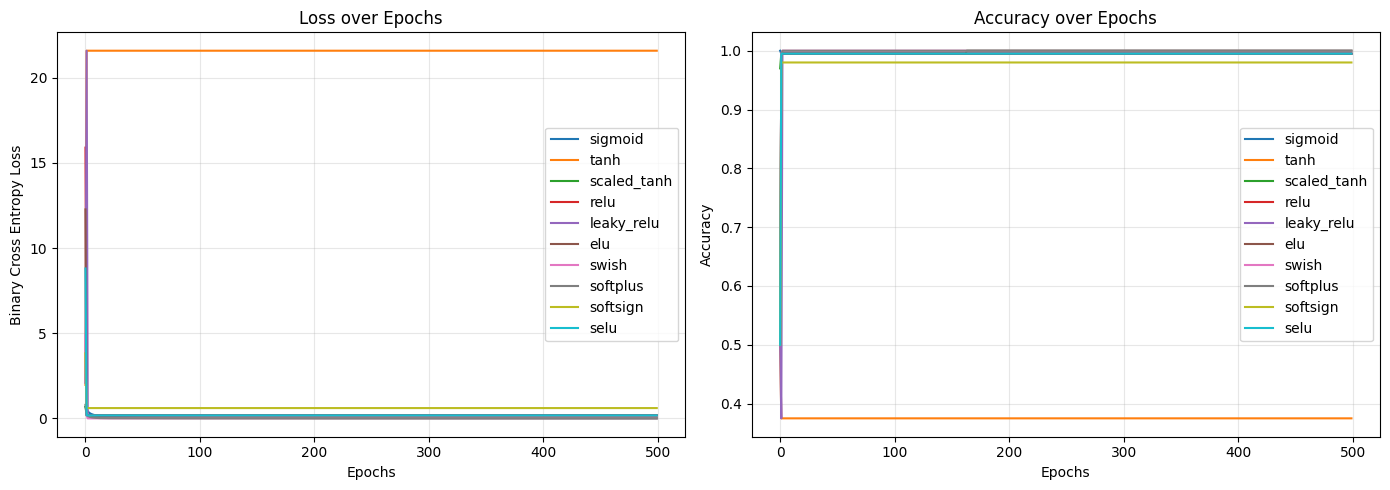

/var/folders/mr/s_4_4nwn31n3tnqmq165d4fh0000gn/T/ipykernel_1750/1929149126.py:46: RuntimeWarning: overflow encountered in exp
  return np.where(z > 0, z, alpha * (np.exp(z) - 1))
/var/folders/mr/s_4_4nwn31n3tnqmq165d4fh0000gn/T/ipykernel_1750/1929149126.py:55: RuntimeWarning: overflow encountered in exp
  return z * (1 / (1 + np.exp(-z)))
/var/folders/mr/s_4_4nwn31n3tnqmq165d4fh0000gn/T/ipykernel_1750/1929149126.py:90: RuntimeWarning: overflow encountered in exp
  return scale * np.where(z > 0, z, alpha * (np.exp(z) - 1))


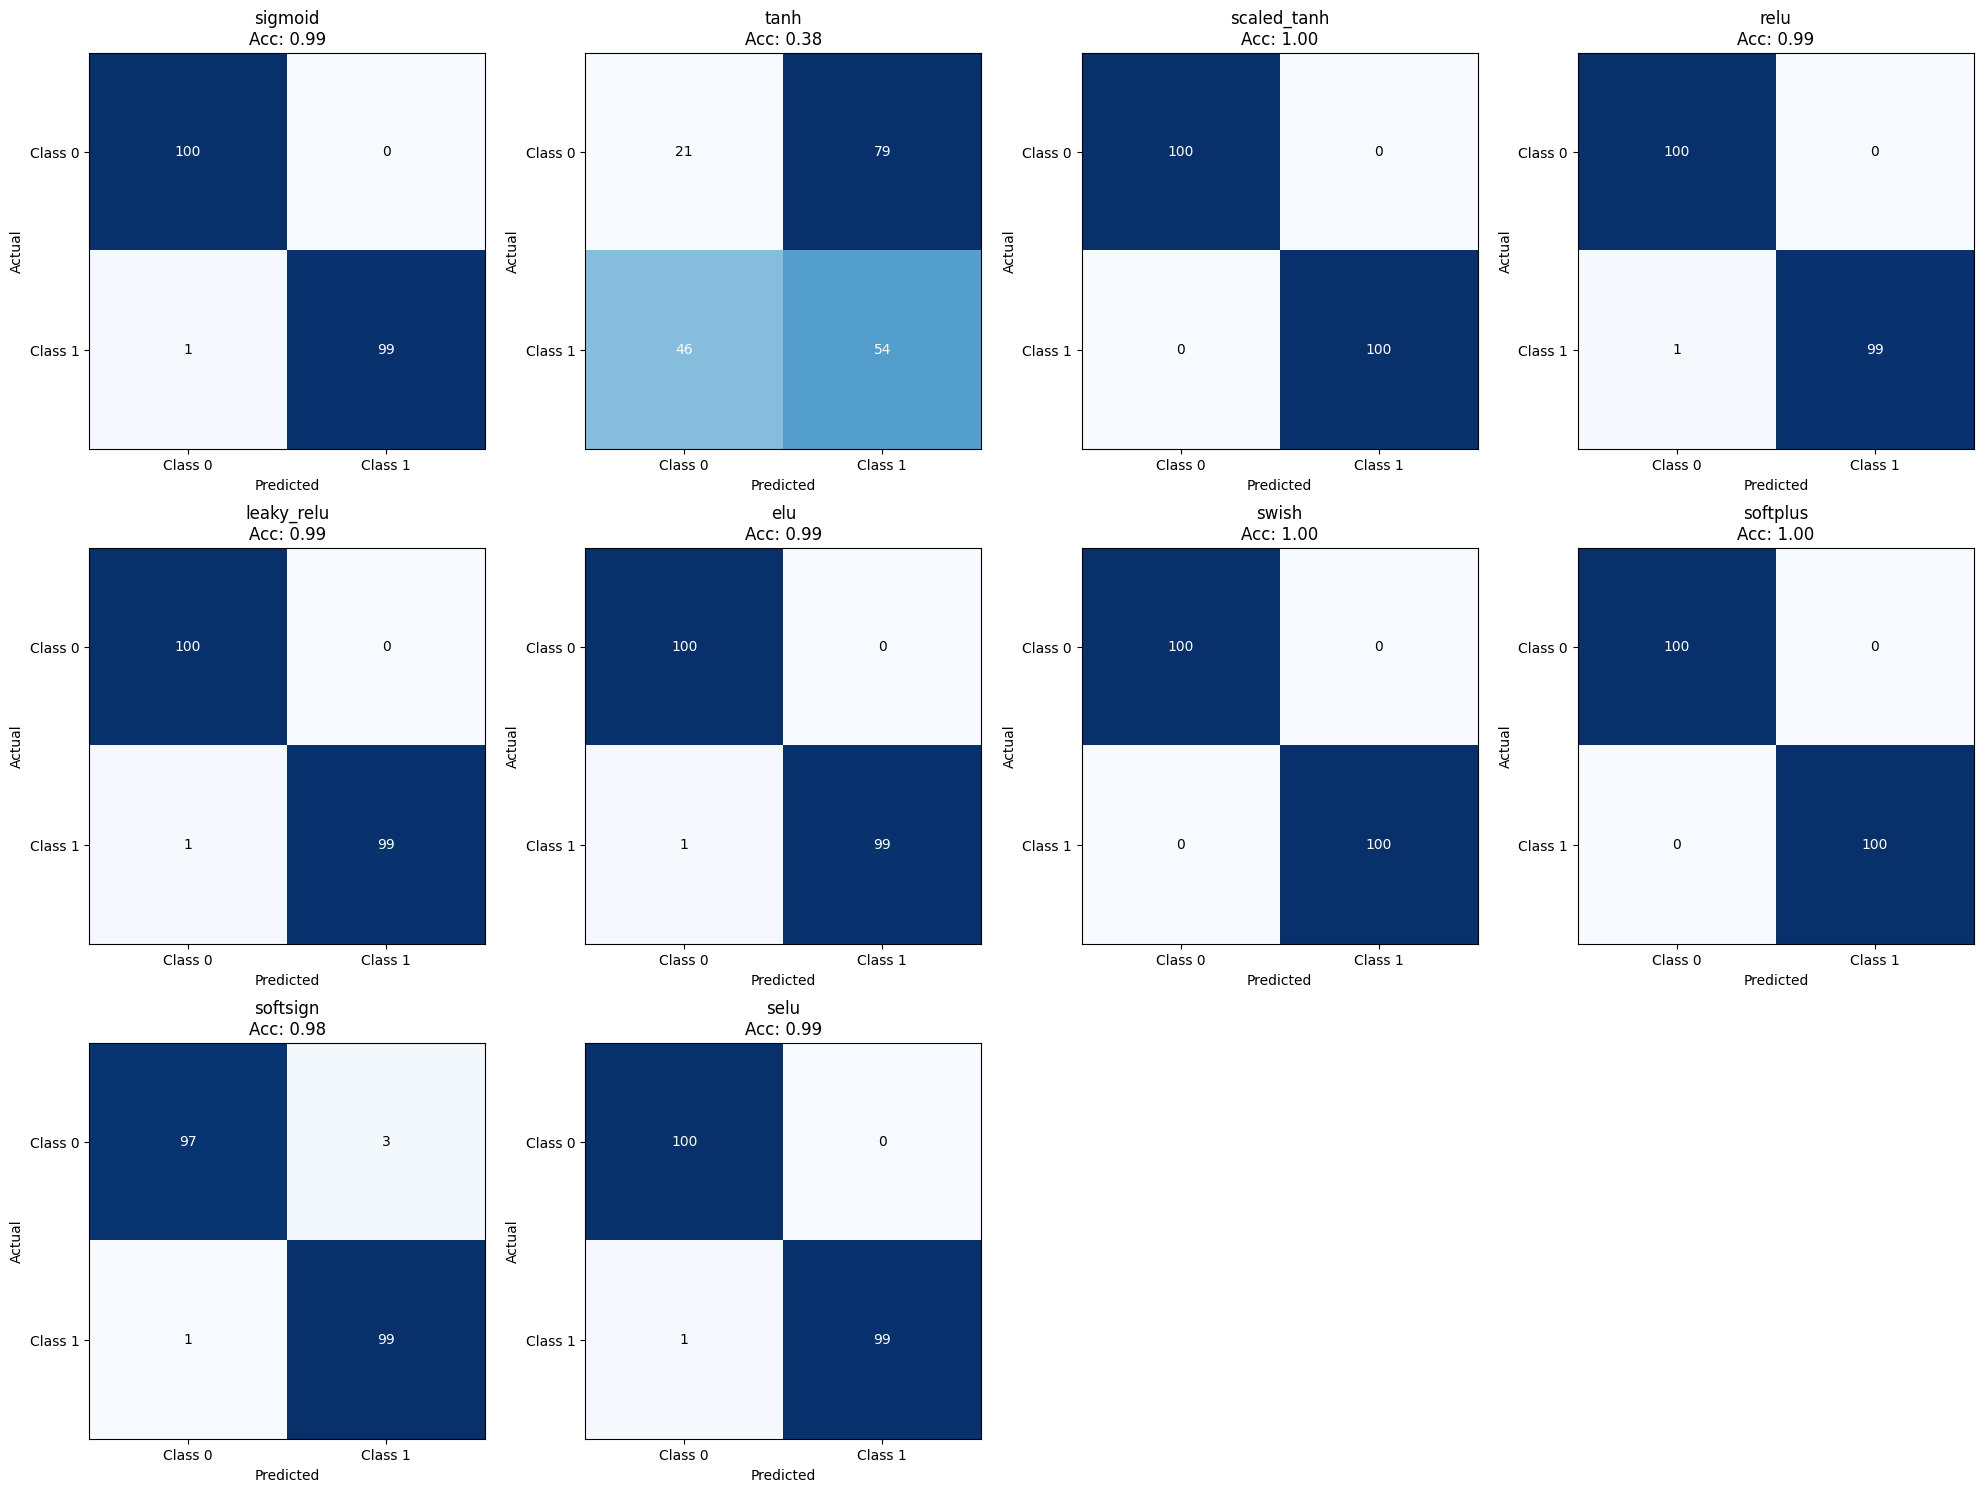

In [25]:
import math

# 1. Plot Loss and Accuracy Curves
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
for act in results:
    plt.plot(results[act]['losses'], label=act)
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 2, 2)
for act in results:
    plt.plot(results[act]['accs'], label=act)
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Plot Confusion Matrices (Dynamic Grid)
num_acts = len(activations_to_test)
cols = 4  # Number of columns we want
rows = math.ceil(num_acts / cols) # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten()

for i, act in enumerate(activations_to_test):
    model = results[act]['model']
    y_pred = model.predict(X)
    
    # Calculate Accuracy and CM
    acc, cm = calculate_metrics(Y, y_pred)
    
    # Plot using Matplotlib (heatmap style)
    # We use 'ax=axes[i]' to target the specific subplot
    im = axes[i].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[i].set_title(f"{act}\nAcc: {acc:.2f}")
    
    # Add labels to the matrix cells
    thresh = cm.max() / 2.
    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            axes[i].text(col, row, format(cm[row, col], 'd'),
                         ha="center", va="center",
                         color="white" if cm[row, col] > thresh else "black")
            
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticks([0, 1])
    axes[i].set_yticks([0, 1])
    axes[i].set_xticklabels(['Class 0', 'Class 1'])
    axes[i].set_yticklabels(['Class 0', 'Class 1'])

# Turn off any empty subplots (if we have 7 items in an 8-slot grid)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()